<a href="https://colab.research.google.com/github/erikaminarikova/Ordinal_Sums/blob/main/example_8_ordinal_sums_testing_data_2classes_different_learning_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 2.9 MB/s eta 0:00:00


In [2]:
import pygad
import numpy as np
import pandas as pd
import statistics
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import image
import seaborn as sns

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import time

In [4]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, mean_squared_error

In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#ordina sums functions

# defining the generic functions for individual classes
def yes_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
    return 1-max(0.0, (((1-x) ** kappa) + ((1-y) ** kappa) - ((1-a) ** kappa))) ** (1 / kappa)

def no_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
        return max(0.0, ((x ** lam) + (y ** lam) - (a ** lam))) ** (1 / lam)

def maybe_function(x: float, y: float, a:float, kappa: float, lam: float, gamma: float = 1) -> float:
    if gamma == 0:
            # r = 0 means we use the geometric mean
        return 0
    elif gamma < 0:
            # r < 0 means we handle cases where x or y are 0
        if x == 0 or y == 0:
            return 0
        else:
                value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    else:
            value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    return statistics.median([0, 1, value])

# defining function for classification: deviding values according thir value to which fuction we use
def classification(x: float, y: float, a: float, kappa: float, lam: float, gamma: float) -> float:
    if x<a and y<a:
        value = no_function(x,y,a,1,lam,1)
    elif x>a and y>a:
        value = yes_function(x,y,a,kappa,1,1)
    else:
        value = maybe_function(x,y,a,1,1,gamma)
    return round(value,4)

In [20]:
#alg for learning parameters in ordinal sums functions
def calculate_param_using_gen_alg(data:[] = []):
    #preparing input-output data
    df = data
    columns=len(df.columns)

    def fitness_func(ga_instance, solution, solution_idx):
        param = np.array(solution)
        df['value']=df.apply(lambda row: abs(row[0]-param[4]), axis =1)
        # parameters for attributes
        i=5
        j=0
        while j < columns-2:
            df['value']=df.apply(lambda row: classification(row['value'], abs(row[j+1]-param[i]), param[0], param[1], param[2], param[3]),
                                                            axis = 1)
            i += 1
            j += 1
        df['error']=df.apply(lambda row: math.exp2(np.abs(row['value'] - row['target'])), axis=1)
        fitness1 = 1/math.sqrt(sum(df['error'])/len(df))
        df['calc_value_class'] = df.apply(lambda row: 0 if (row['value']<param[0]) else 1, axis=1)
        df['target_class'] = df.apply(lambda row: 0 if (row['target']<param[0]) else 1, axis=1)
        fitness2 = f1_score(df[['calc_value_class']].values, df[['target_class']].values)
        fitness = 0.5*fitness1 + 0.5*fitness2
        return fitness

    fitness_function = fitness_func

    num_generations = 60
    num_parents_mating = 12

    sol_per_pop = 24
    num_genes = 8 #number of learnt (tuned) parameters

    init_range_low = 0
    init_range_high = 1

    parent_selection_type = "sss"
    keep_parents = 2

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 15

    ga_instance = pygad.GA(num_generations=num_generations,
                            num_parents_mating=num_parents_mating,
                            fitness_func=fitness_function,
                            sol_per_pop=sol_per_pop,
                            num_genes=num_genes,
                            init_range_low=init_range_low,
                            init_range_high=init_range_high,
                            parent_selection_type=parent_selection_type,
                            keep_parents=keep_parents,
                            crossover_type=crossover_type,
                            mutation_type=mutation_type,
                            mutation_percent_genes=mutation_percent_genes,
                            gene_space=[{'low': 0, 'high': 1},{'low': 0, 'high': 3},
                                        {'low': 0, 'high': 3},{'low': 0, 'high': 1},
                                        [0,1], [0,1], [0,1], [0,1]])

    ga_instance.run()

    ga_instance.plot_fitness()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    #filename = 'genetic'
    #ga_instance.save(filename=filename)

    solution_param= np.array(solution)
    df['calc_value']=df.apply(lambda row: abs(row[0]-solution_param[4]), axis = 1)
    columns=len(df.columns)
    j=0
    i=5
    while j < columns-7:
        df['calc_value']=df.apply(lambda row: classification(row['calc_value'], abs(row[j+1] - solution_param[i]), solution_param[0], solution_param[1], solution_param[2], solution_param[3]),
                                                        axis = 1)
        i += 1
        j += 1
    df['calc_value_class'] = df.apply(lambda row: 0 if (row['calc_value']<solution_param[0]) else 1, axis=1)
    df['target_class'] = df.apply(lambda row: 0 if (row['target']<solution_param[0]) else 1, axis=1)
    merge_data = df
    # merge_data.to_csv("data/output.csv")
    mean_error = (sum(merge_data['error'])) / len(merge_data)
    kappa_result = solution_param[1]
    lam_result = solution_param[2]
    gamma_result = solution_param[3]
    a_result = solution_param[0]
    return merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, solution_param, solution_fitness, solution_idx



In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Fuction to despay relevant results
def show_results(data, mean_error, gamma_result, lam_result, kappa_result, a_result):
    # calculate the mean squared error
    target_values = data[['target']].values
    value = data[['calc_value']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Results:')
    if all(col in data.columns for col in ['value','error']):
      print(data.drop(columns=['value','error']))
    else:
      print(data)
    #print('mean error: ', mean_error)
    print('\u03B3 = ', round(gamma_result, 4))
    print('\u03BB = ', round(lam_result, 4))
    print('\u03BA = ', round(kappa_result, 4))
    print('a = ', round(a_result, 4))
    print('Mean squared error = ', round(MSE, 4))
    print('Root Mean Square Error = ', round(RMSE, 4))

In [10]:
def print_attr_coef(data, sol_param):
  coeficients = []
  for i in sol_param:
    if i == 1:
      pom = '1-decreasing'
      coeficients.append(pom)
    elif i == 0:
      pom = '0-increasing'
      coeficients.append(pom)

  name_columns = data.drop(columns=['target']).columns

  merge_list = name_columns + [': '] + coeficients
  for list in merge_list:
    print(list)

In [11]:
def view_chart(a, kappa, lam):
    """ if df:
        variables_for_plot = st.multiselect('Select 2 dependent variables for plot:', df.columns, max_selections=2)
        if variables_for_plot:
            df_for_plot = df[variables_for_plot]
            x=df_for_plot.iloc[:, 0]
            y=df_for_plot.iloc[:, 1]
            plt.scatter(x,y) """
    plt.figure(figsize=(3, 3))
    plt.subplot(111)
    y = np.arange(0, 1, 0.05)
    x = [a] * len(y)
    plt.scatter(x, y, c = 'black', s = 1)

    x = np.arange(0, 1, 0.05)
    y = [a] * len(x)
    plt.scatter(x, y, c = 'black', s = 1)

    y1 = np.arange(a, 1.0, 0.001)
    b=1
    x1 = 1-((1-a)**kappa-(1-y1)**kappa)**(1/kappa)
    plt.plot(x1, y1, c = 'red')
    plt.fill_between(y1,x1, b, color='red')

    y2 = np.arange(0, a, 0.01)
    x2 = ((a**lam)-(y2**lam))**(1/lam)
    plt.plot(y2, x2, c = 'green')
    plt.fill_between(y2,x2,color='green')

    # y3 = np.arange(a, 1.01, 0.01)
    # x3 = 1-(((1-a)**kappa)-((1-y3)**kappa))**(1/kappa)
    # z = np.min(b, x2)
    # plt.fill_between(y3,x3,y2=0, color='blue')

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.annotate('D', xy=(a, a), xytext=(a + 0.2, a + 0.2), fontsize=12)
    plt.annotate('C', xy=(a, a), xytext=(a - 0.3, a - 0.3), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a - 0.3, a + 0.2), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a + 0.2, a - 0.3), fontsize=12)

    plt.annotate('a', xy=(a, a), xytext=(a - 0.04, a - 0.63), fontsize=12)
    plt.annotate('a', xy=(a, a), xytext=(a - 0.63, a - 0.04), fontsize=12)

    return (plt)

In [21]:
import pandas as pd

# Define the data for the DataFrame
data = {
    "x": [0.00, 1.00, 0.00, 0.50, 1.00, 0.00, 0.80, 0.00, 0.75, 0.58, 1.00, 0.00, 0.98, 0.20, 0.04, 0.40, 0.90, 1.00],
    "y": [0.00, 0.00, 0.00, 0.50, 0.00, 1.00, 0.80, 1.00, 0.27, 0.96, 0.50, 0.00, 0.98, 0.55, 0.69, 0.20, 0.80, 1.00],
    "z": [0.00, 0.00, 0.00, 0.50, 1.00, 0.00, 0.50, 1.00, 0.80, 0.80, 0.22, 0.50, 0.30, 0.70, 0.20, 0.40, 0.75, 1.00],
    "w": [0.00, 0.00, 1.00, 0.50, 0.00, 1.00, 0.20, 1.00, 0.25, 0.50, 0.00, 1.00, 0.80, 0.40, 0.70, 0.35, 1.00, 1.00],
    "target": [0.00, 0.00, 0.50, 0.50, 0.50, 0.50, 0.70, 1.00, 0.57, 1.00, 0.22, 0.50, 1.00, 0.35, 0.20, 0.00, 1.00, 1.00]
}

# Create the DataFrame
testing_df = pd.DataFrame(data)
data = pd.DataFrame(data)

# Display the DataFrame
print(testing_df)


       x     y     z     w  target
0   0.00  0.00  0.00  0.00    0.00
1   1.00  0.00  0.00  0.00    0.00
2   0.00  0.00  0.00  1.00    0.50
3   0.50  0.50  0.50  0.50    0.50
4   1.00  0.00  1.00  0.00    0.50
5   0.00  1.00  0.00  1.00    0.50
6   0.80  0.80  0.50  0.20    0.70
7   0.00  1.00  1.00  1.00    1.00
8   0.75  0.27  0.80  0.25    0.57
9   0.58  0.96  0.80  0.50    1.00
10  1.00  0.50  0.22  0.00    0.22
11  0.00  0.00  0.50  1.00    0.50
12  0.98  0.98  0.30  0.80    1.00
13  0.20  0.55  0.70  0.40    0.35
14  0.04  0.69  0.20  0.70    0.20
15  0.40  0.20  0.40  0.35    0.00
16  0.90  0.80  0.75  1.00    1.00
17  1.00  1.00  1.00  1.00    1.00


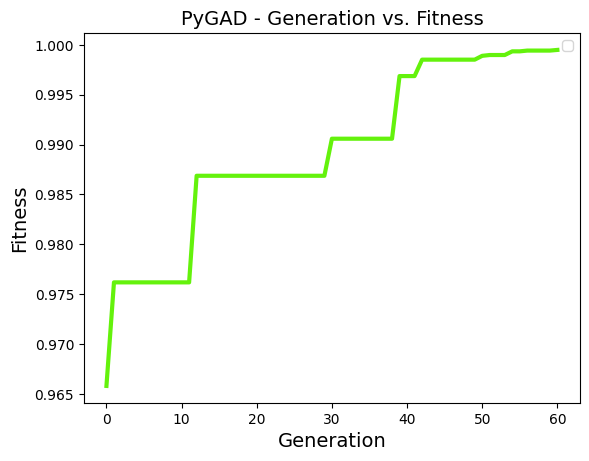

Results:
       x     y     z     w  target  calc_value_class  target_class  calc_value
0   0.00  0.00  0.00  0.00    0.00                 0             0      0.0000
1   1.00  0.00  0.00  0.00    0.00                 0             0      0.0000
2   0.00  0.00  0.00  1.00    0.50                 1             1      0.5045
3   0.50  0.50  0.50  0.50    0.50                 1             1      0.5042
4   1.00  0.00  1.00  0.00    0.50                 1             1      0.5045
5   0.00  1.00  0.00  1.00    0.50                 1             1      0.5104
6   0.80  0.80  0.50  0.20    0.70                 1             1      0.7033
7   0.00  1.00  1.00  1.00    1.00                 1             1      1.0000
8   0.75  0.27  0.80  0.25    0.57                 1             1      0.5766
9   0.58  0.96  0.80  0.50    1.00                 1             1      1.0000
10  1.00  0.50  0.22  0.00    0.22                 0             0      0.2259
11  0.00  0.00  0.50  1.00    0.50         

In [22]:
start_time = time.time()
merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, sol_param, solution_fitness, solution_idx = calculate_param_using_gen_alg(data)

show_results(merge_data, mean_error, gamma_result, lam_result, kappa_result, a_result)
print_attr_coef(testing_df, sol_param)
print("Parameters of the best solution : {solution_idx}".format(solution_idx=solution_idx))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print('time:', (time.time()-start_time)/60)

In [14]:
def calculate_tests(target_values, value):
  print('Accuracy score = ', accuracy_score(target_values, value))
  print('F1 = ', f1_score(target_values, value, average= 'macro'))
  print('Precision = ', precision_score(target_values, value, average= 'macro'))
  print('Recall = ', recall_score(target_values, value, average= 'macro'))
  #confusion matrix
  confusion_matrix = metrics.confusion_matrix(target_values, value)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  cm_display.plot()
  plt.show()

Accuracy score =  1.0
F1 =  1.0
Precision =  1.0
Recall =  1.0


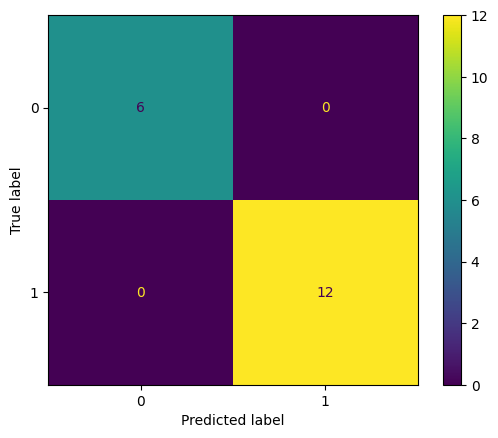

In [23]:
# tests for train dataset: testing_df
calculate_tests(merge_data[["calc_value_class"]].values, merge_data[['target_class']].values)

<ipython-input-5-6737d8efe725>:21: RuntimeWarning: invalid value encountered in power
  x1 = 1-((1-a)**kappa-(1-y1)**kappa)**(1/kappa)


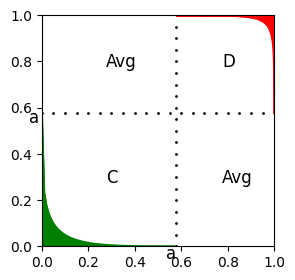

In [ ]:
# df = pd.DataFrame()
# chart = view_chart(df, 0.2305, 0.8658, 3.7278, 0.9559)
# chart = view_chart(0.5,1,1)

chart = view_chart(0.576, 0.1413*2, 0.1663*2)
chart.show()

In [16]:
# Define the data for the DataFrame
data = {
    "x": [0.10, 0.95, 0.05, 0.60, 0.85, 0.15, 0.72, 0.05, 0.68, 0.47, 0.92, 0.08, 0.88, 0.25, 0.12, 0.35, 0.82, 0.97],
    "y": [0.05, 0.07, 0.02, 0.45, 0.03, 0.98, 0.76, 0.92, 0.30, 0.88, 0.46, 0.07, 0.91, 0.50, 0.65, 0.25, 0.78, 0.94],
    "z": [0.03, 0.06, 0.09, 0.55, 0.95, 0.12, 0.53, 0.97, 0.78, 0.75, 0.18, 0.52, 0.32, 0.65, 0.25, 0.42, 0.72, 0.99],
    "w": [0.07, 0.04, 0.98, 0.52, 0.06, 0.93, 0.25, 0.89, 0.22, 0.55, 0.05, 0.95, 0.77, 0.45, 0.60, 0.40, 0.99, 0.96],
    "target": [0.00, 0.00, 0.48, 0.62, 0.39, 0.68, 0.75, 1.00, 0.48, 1.00, 0.11, 0.47, 1.00, 0.35, 0.12, 0.00, 1.00, 1.00]
}


# Create the DataFrame
df_test = pd.DataFrame(data)


In [17]:
# Calculate ordinal sums on test dataset
columns=len(df_test.columns)
df_test['calc_value']=df_test.apply(lambda row: row[0], axis =1)
# parameters for attributes
i=5
j=0
while j < columns-2:
  df_test['calc_value']=df_test.apply(lambda row: classification(row['calc_value'], abs(row[j+1]-sol_param[i]), sol_param[0], sol_param[1], sol_param[2], sol_param[3]), axis = 1)
  i += 1
  j += 1
show_results(df_test, 0, 0, 0, 0, 0)

Results:
       x     y     z     w  target  calc_value
0   0.10  0.05  0.03  0.07    0.00      0.0000
1   0.95  0.07  0.06  0.04    0.00      0.0000
2   0.05  0.02  0.09  0.98    0.48      0.4756
3   0.60  0.45  0.55  0.52    0.62      0.6467
4   0.85  0.03  0.95  0.06    0.39      0.3985
5   0.15  0.98  0.12  0.93    0.68      0.6912
6   0.72  0.76  0.53  0.25    0.75      0.7206
7   0.05  0.92  0.97  0.89    1.00      1.0000
8   0.68  0.30  0.78  0.22    0.48      0.5038
9   0.47  0.88  0.75  0.55    1.00      1.0000
10  0.92  0.46  0.18  0.05    0.11      0.1303
11  0.08  0.07  0.52  0.95    0.47      0.4767
12  0.88  0.91  0.32  0.77    1.00      1.0000
13  0.25  0.50  0.65  0.45    0.35      0.3703
14  0.12  0.65  0.25  0.60    0.12      0.1070
15  0.35  0.25  0.42  0.40    0.00      0.0000
16  0.82  0.78  0.72  0.99    1.00      1.0000
17  0.97  0.94  0.99  0.96    1.00      1.0000
γ =  0
λ =  0
κ =  0
a =  0
Mean squared error =  0.0002
Root Mean Square Error =  0.0137


In [18]:
#prepare data for tests
df_test['calc_value_class'] = df_test.apply(lambda row: 0 if (row['calc_value']<0.4664) else 1, axis=1)
df_test['target_class'] = df_test.apply(lambda row: 0 if (row['target']<0.4664) else 1, axis=1)

Accuracy score =  1.0
F1 =  1.0
Precision =  1.0
Recall =  1.0


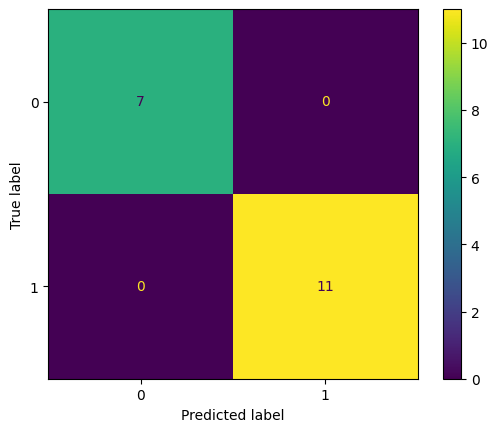

In [19]:
# tests for train dataset:
calculate_tests(df_test[['calc_value_class']].values, df_test[['target_class']].values)